## Cosmic Ray Acceleration and Interactions with Clouds (CRAIC) Tutorial

This python package models:
* properties of an astrophysical accelerator (such as a supernova remnant)
* propagation of cosmic rays through the interstellar medium
* interactions with target material such as clouds
* resulting gamma-ray and neutrino flux

The structure is divided into several modules, as well as a couple of scripts and is a work in progress. 
This notebook gives some example usage. 
Prerequisites:
- numpy
- astropy
- matplotlib

First, import the relevant packages and functions from craic.

In [1]:
import sys
import numpy as np
import astropy.constants as c
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import some useful modules

from craic.particles import particles as pa
from craic.transport import transport as tr
from craic.accelerator import accelerator as ac
from craic.flux import flux as fl
from craic import injection as inj
from craic.SNR_Cloud_Flux import SNR_Cloud_Flux

In [3]:
# Set figure parameters

SMALL_SIZE = 11
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [4]:
#Note: each of these classes is initiated with default values that can be altered

acel = ac() #default explosion energy 1e51 erg
part = pa() #default power-law index alpha = 2, default energy budget 1e50 erg
tran = tr() #default diffusion coefficient 3x10^27 cm^2/s at 1 GeV, default chi = 0.05
fluxfunc = fl() #default index alpha = 2

Let's start by exploring the functions available with a few modules in turn.

### accelerator 

The 'escape_time' function provides the energy dependent escape time for particles accelerated in the remnants type IIb or type Ia supernovae. 

In [5]:
print("The escape time of accelerated 1 PeV particles in a type IIb supernova is", acel.escape_time(Ep=1e6*u.GeV,typeIIb=True)[0])

The escape time of accelerated 1 PeV particles in a type IIb supernova is 1596.3332592430165 yr


In [6]:
print("The escape time of accelerated 1 PeV particles in a type Ia supernova is", acel.escape_time(Ep=1e6*u.GeV,typeIIb=False))

The escape time of accelerated 1 PeV particles in a type Ia supernova is 234.0000000000412 yr


The supernova radius is calculated as a function of age assuming evolution in the Sedov stage. 

In [7]:
print("The radius of an expanding supernova with an age of 1000 years in the Sedov stage is", acel.SNR_Radius(time=1e3*u.yr)[0])

The radius of an expanding supernova with an age of 1000 years in the Sedov stage is 4.985557942259198 pc


This expression can be inverted to obtain the SNR age, given its radius. 

In [8]:
print("The age of a 10-pc expanding supernova in the Sedov stage is", acel.SNR_age(size=10.*u.pc)[0])

The age of a 10-pc expanding supernova in the Sedov stage is 5697.909932261937 yr


### particles

The particles class contains functions describing the interaction cross-section and cooling time for p-p collisions, using the parameterisation of Kafexhiu et al (2014). 

It also contains a normalisation of the energy budget based on the particle spectrum.

In [9]:
print("The p-p interaction cross-section at 100 TeV is", part.sig_ppEK(Ep=1e5*u.GeV))

The p-p interaction cross-section at 100 TeV is 4.785567213707722e-26 cm2


In [10]:
print("The cooling time for p-p interactions at 100 TeV is", part.t_ppEK(dens=500.*u.cm**-3, Ep=1e6*u.GeV).to(u.kyr))

The cooling time for p-p interactions at 100 TeV is 82.13042883370403 kyr


In [11]:
#Default values for the energy range are 10 GeV to 3 PeV
print("The normalisation is", part.NormEbudget())

The normalisation is 4.9490468144220834e+51 GeV


### transport

The transport class contains functions for the energy dependence of the diffusion coefficient and for the diffusion radius. It also contains a function describing the magnetic field strength in clouds calculated based on Crutcher et al (2010). 

In [12]:
print(r"The magnetic field strength in a cloud with density 500 cm^-3 is", tran.B_mag(np.array([500.])*u.cm**(-3))[0])

The magnetic field strength in a cloud with density 500 cm^-3 is 13.938039380837822 uG


In [13]:
print("The diffusion coefficient in a cloud is", tran.Diffusion_Coefficient(1e5*u.GeV,np.array([200.])*u.cm**(-3))[0])

The diffusion coefficient in a cloud is 2.598076211353316e+27 cm2 / s


The last argument is a flag indicating whether or not the diffusion is in the ISM or a cloud. 
The default density assumed for the ISM is 1 cm$^{-3}$.

In [14]:
print("The diffusion coefficient in the ISM is", tran.Diffusion_Coefficient(1e5*u.GeV,acel.nh2ism,ism=1)) #flag needed?

The diffusion coefficient in the ISM is 9.486832980505138e+28 cm2 / s


As an example, how far could PeV particles travel in the ISM from a 1000 yr old SNR?
And in a dense cloud during 100 yr?

In [15]:
print("The diffusion radius in the ISM is", tran.R_diffusion(1e6*u.GeV, a=np.array([1e3])*u.yr, dens=acel.nh2ism,ism=1).to('pc')[0])

The diffusion radius in the ISM is 63.065531665494376 pc


In [16]:
print("The diffusion radius in the cloud is", tran.R_diffusion(1e6*u.GeV, a=np.array([1e2])*u.yr, dens=np.array([100.])*u.cm**(-3)).to('pc')[0])

The diffusion radius in the cloud is 3.3003300762775982 pc


### flux

The flux module contains the gamma and neutrino kernels to evaluate the flux resulting from a protons at a given energy based on Kelner et al. 2006, and the cell based integration for flux throughout a cloud. 

In [17]:
test_Eg = 10.**np.linspace(np.log10(.1),np.log10(100))*u.TeV # TeV
test_Ep = 10.**np.linspace(np.log10(1e3),np.log10(1e6))*u.GeV # GeV

In [18]:
# Calculate the gamma-ray flux
F_GAM = fluxfunc.compute_gamma_kernel(Eg=test_Eg,Ep=test_Ep)

### injection

The injection module computes the proton flux from point or extended sources in the impulsive or continuous injection cases given a set of source properties, based on Aharonian and Atoyan (1996). 

In [19]:
N0 = 1e49*u.erg
test_pflux = inj.compute_pflux_impulsive_point(N_0=N0,Ep=1e5*u.GeV,d=np.array([50])*u.pc,
                             a=np.array([2e4])*u.yr,dens=np.array([200.])*u.cm**(-3))

In [20]:
print("The calculated proton flux is", test_pflux[0])

The calculated proton flux is 7.980614381401864e-22 1 / (GeV cm3)


### Model chain and flux prediction

To run through the full chain - i.e. the model used in the paper with particle acceleration at source, propagation through the ISM and interaction with target cloud to produce gamma-ray and neutrino flux, use the function SNR_Cloud_Flux. The model follows Kelner et al (2006).

Input parameters:
* nh2 = target material density ()
* dist = separation distance accelerator to target cloud
* age = SNR age

Optional input parameters:
* chi = diffusion suppression factor
* distance_SNR = distance of SNR from Earth (~ pc)
* radius_MC = radius of the cloud (~ pc)
* accel_type = acceleration type (impulsive or continuous)
* snr_typeII = a flag for type II or type IA SNRs
* F_gal = flag whether or not to include which galactic CR spectrum: F_gal=False (default), "AMS-O2", "DAMPE"
* palpha = power law index of the proton spectrum 
* D_fast = flag fast or slow diffusion in the ISM (changes the normalisation)
* flag_low = include low energy correction ~GeV range

In [21]:
#Function returns as arrays the gamma-ray energy, gamma-ray flux and neutrino flux

SNRcloud = SNR_Cloud_Flux() # Change optional input parameters here if needed

Eg, phi, phi_nu, phi_nue, phi_numu, phi_nutau = SNRcloud.compute_flux(
    nh2=100*u.cm**-3,
    dist=50*u.pc,
    age=2e4*u.yr
)


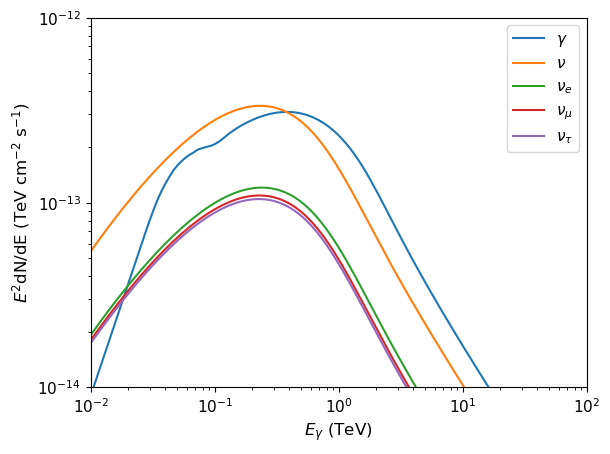

In [22]:
#plot the resulting spectra
plt.plot(Eg, Eg*Eg*(phi),label=r'$\gamma$')
plt.plot(Eg, Eg*Eg*(phi_nu),label=r'$\nu$')
plt.plot(Eg, Eg*Eg*(phi_nue),label=r'$\nu_e$')
plt.plot(Eg, Eg*Eg*(phi_numu),label=r'$\nu_\mu$')
plt.plot(Eg, Eg*Eg*(phi_nutau),label=r'$\nu_\tau$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14,1e-12)
# plt.ylim(1e-13, 1e-11)
plt.xlim(0.01,100.)
plt.xlabel(r"$E_{\gamma}$ (TeV)")
plt.ylabel(r"$E^2$dN/dE (TeV cm$^{-2}$ s$^{-1}$)")
plt.legend()

None